In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import glob
import datetime

In [2]:
import WNN

Using TensorFlow backend.


In [3]:
wt_list = ['WTG01','WTG02','WTG03','WTG04','WTG05','WTG06','WTG07','WTG08',
         'WTG09','WTG10','WTG11','WTG12','WTG13','WTG14','WTG15','WTG16']

In [4]:
wt_dict = dict(zip(wt_list,range(1,17)))

## Load and prepare WRF and Juvent data

In [5]:
def sanitize_time_juvent(s):
    s_tmp = s.split(':')
    minutes = str(int(s_tmp[1]) - int(s_tmp[1]) % 10)
    return ''.join([s_tmp[0],':',minutes])
    
def get_dm(time_stamp):
    return str(time_stamp.day) +'_'+str(time_stamp.month)

juvent_data = pd.read_csv('request_juvent/Juvent_Jan_2020.csv')
juvent_data['Time'] = pd.to_datetime(juvent_data['Time'].apply(sanitize_time_juvent))
juvent_data['Time'] = juvent_data['Time']-datetime.timedelta(hours=1)
juvent_data = juvent_data.sort_values(by = 'Time',ascending=False).drop(columns=['Unnamed: 0'])

juvent_data.head()

,Time,Turbine_id,Production,Power,Wind_Speed,Wind_Direction,Temperature
27279,2020-01-15 15:10:00,16,26458,867,31.0,SW,6.0
27271,2020-01-15 15:10:00,8,29129,671,23.0,S,9.0
27264,2020-01-15 15:10:00,1,18657,336,21.0,S,6.0
27265,2020-01-15 15:10:00,2,11506,140,16.0,S,7.0
27266,2020-01-15 15:10:00,3,18875,391,22.0,SW,6.0


In [54]:
%%capture

wrf_outputs = glob.glob('data_from_cluster/WRF_data_2020_*.txt')  #LOAD ALL THE DATA FROM 2020
df_95 = {}
df_150 = {}
for wt in wt_list:
    df1,df2 = pd.DataFrame(),pd.DataFrame() #Prepare WRF data for the NN and concatenate it
    for file in wrf_outputs: 
        df1_new,df2_new = WNN.prepare_new_data(file) ### It comes from WNN.py
        df1 = pd.concat([df1,df1_new[wt]], ignore_index=True)
        df2 = pd.concat([df2,df2_new[wt]], ignore_index=True)
    
    juvent_tmp = juvent_data[juvent_data.Turbine_id == wt_dict[wt]].copy().drop('Turbine_id',axis=1)
    
    # First we need to recreate the two dataframes as input for the neural network, here we take the df1, and df2 from above
    df1 = pd.merge(df1,juvent_tmp,left_on='Date-time', right_on='Time')
    df1 = df1.drop_duplicates(subset='Date-time', keep="first") 
    df1 = df1.sort_values(by='Date-time',ascending = False).reset_index(drop=True) #ascending = False is imporant
    
    df2 = pd.merge(df2,juvent_tmp,left_on='Date-time', right_on='Time')
    df2 = df2.drop_duplicates(subset='Date-time', keep="first") 
    df2 = df2.sort_values(by='Date-time',ascending = False).reset_index(drop=True) #ascending = False is imporant
    
    df_95[wt] = df1    
    df_150[wt] = df2

In [ ]:
WNN.prepare_new_data()

In [53]:
juvent_data[juvent_data.Turbine_id == wt_dict[wt]]

,Time,Turbine_id,Production,Power,Wind_Speed,Wind_Direction,Temperature
27264,2020-01-15 15:10:00,1,18657,336,21.0,S,6.0
27248,2020-01-15 15:00:00,1,18601,308,20.0,S,6.0
27232,2020-01-15 14:50:00,1,18550,294,19.0,S,6.0
27216,2020-01-15 14:40:00,1,18501,364,21.0,S,6.0
27200,2020-01-15 14:30:00,1,18440,559,24.0,SW,7.0
...,...,...,...,...,...,...,...
64,2020-01-03 14:00:00,1,25824,1118,29.0,SW,5.0
48,2020-01-03 13:50:00,1,25638,797,27.0,SW,5.0
32,2020-01-03 13:40:00,1,25505,755,26.0,SW,5.0
16,2020-01-03 13:30:00,1,25379,517,23.0,SW,5.0


In [9]:
#SAVE THE DATA

#with open('df_95_jan.pickle', 'wb') as handle:
#    pickle.dump(df_95, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('df_150_jan.pickle', 'wb') as handle:
#    pickle.dump(df_150, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
# LOAD THE DATA  see the WindNeuralNetwork.ipynb to see where it comes from
with open('df_agg95_kw_goodtime.pickle', 'rb') as handle:
    df_agg95 = pickle.load(handle)               #Data at 95m above the ground
with open('df_agg150_kw_goodtime.pickle', 'rb') as handle:
    df_agg150 = pickle.load(handle)               #Data at 150m above the ground

In [58]:
wnn_dict={}
for wt in wt_list:
    wnn=WNN.WindNeuralNetwork(df_agg95[wt],df_agg150[wt],look_back=12,q_weight=2,quantile=0.6,time_jump=2)
    wnn.prep_data()
    wnn.create_and_fit_model()
    wnn_dict[wt]=wnn

Train on 4820 samples, validate on 851 samples
Epoch 1/30
4820/4820 [==============================] - 1s 198us/step - loss: 0.7657 - val_loss: 0.5096
Epoch 2/30
4820/4820 [==============================] - 0s 40us/step - loss: 0.4832 - val_loss: 0.4281
Epoch 3/30
4820/4820 [==============================] - 0s 40us/step - loss: 0.4224 - val_loss: 0.3980
Epoch 4/30
4820/4820 [==============================] - 0s 40us/step - loss: 0.4073 - val_loss: 0.3369
Epoch 5/30
4820/4820 [==============================] - 0s 40us/step - loss: 0.3770 - val_loss: 0.3611
Epoch 6/30
4820/4820 [==============================] - 0s 39us/step - loss: 0.3543 - val_loss: 0.3137
Epoch 7/30
4820/4820 [==============================] - 0s 40us/step - loss: 0.3267 - val_loss: 0.3199
Epoch 8/30
4820/4820 [==============================] - 0s 40us/step - loss: 0.3213 - val_loss: 0.2941
Epoch 9/30
4820/4820 [==============================] - 0s 40us/step - loss: 0.3111 - val_loss: 0.2535
Epoch 10/30
4820/4820 [==

In [59]:
#LOAD THE DATA

with open('df_95_jan.pickle', 'rb') as handle:
    df_95 = pickle.load(handle)
with open('df_150_jan.pickle', 'rb') as handle:
    df_150 = pickle.load(handle)

In [60]:
for wt in wt_list:
    wnn_dict[wt].re_train_model(df_95[wt],df_150[wt],var='Power')

Train on 1196 samples, validate on 212 samples
Epoch 1/30
1196/1196 [==============================] - 0s 42us/step - loss: 0.4650 - val_loss: 0.2634
Epoch 2/30
1196/1196 [==============================] - 0s 40us/step - loss: 0.3361 - val_loss: 0.2550
Epoch 3/30
1196/1196 [==============================] - 0s 40us/step - loss: 0.3012 - val_loss: 0.2111
Epoch 4/30
1196/1196 [==============================] - 0s 40us/step - loss: 0.2897 - val_loss: 0.2004
Epoch 5/30
1196/1196 [==============================] - 0s 42us/step - loss: 0.2600 - val_loss: 0.2108
Epoch 6/30
1196/1196 [==============================] - 0s 41us/step - loss: 0.2549 - val_loss: 0.2576
Epoch 7/30
1196/1196 [==============================] - 0s 40us/step - loss: 0.2311 - val_loss: 0.3125
Train on 1196 samples, validate on 212 samples
Epoch 1/30
1196/1196 [==============================] - 0s 41us/step - loss: 0.7017 - val_loss: 1.0090
Epoch 2/30
1196/1196 [==============================] - 0s 40us/step - loss: 0.391

In [61]:
with open('wnn_dict_kw_retrained.pickle', 'wb') as handle:
    pickle.dump(wnn_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
df_agg95[wt]

,Date-time,Ws,Wdir,T,P,WT_WS,WT_WDIR,WT_T,WT_Power,WT_state,Day_Month
2018-12-30 21:00:00,2018-12-30 21:00:00,3.948424046263054,57.419278826344495,283.42948800731443,900.0241040197163,1.3,28.3,7.0,-2.682,0.0,30_12
2018-12-30 20:50:00,2018-12-30 20:50:00,4.026293117671963,57.802612020808475,283.4351485504396,899.9800650942702,1.9,68.7,6.0,-2.556,0.0,30_12
2018-12-30 20:40:00,2018-12-30 20:40:00,4.10820498855134,57.656396355406,283.41144331795965,899.950077180574,2.7,74.2,5.0,-3.354,0.0,30_12
2018-12-30 20:30:00,2018-12-30 20:30:00,4.170483402494468,57.24741391766256,283.36145422236996,899.9304830228934,3.0,64.7,5.0,-3.762,0.0,30_12
2018-12-30 20:20:00,2018-12-30 20:20:00,4.211759354962862,56.11628013749908,283.31313007487597,899.8987454938338,2.8,48.5,6.0,-3.336,0.0,30_12
...,...,...,...,...,...,...,...,...,...,...,...
2018-06-01 09:40:00,2018-06-01 09:40:00,4.151199113635614,286.95765213942923,295.50515470373983,891.2792283359854,2.6,285.0,14.0,-7.134,3.0,1_6
2018-06-01 09:30:00,2018-06-01 09:30:00,4.246682995562934,288.84320467877126,295.47766616250317,890.9009482442605,2.4,274.2,14.0,-7.164,0.0,1_6
2018-06-01 09:20:00,2018-06-01 09:20:00,3.9206480451257035,286.58876248177233,295.3942283024072,891.3389403636018,2.9,265.8,14.0,-8.382,0.0,1_6
2018-06-01 09:10:00,2018-06-01 09:10:00,3.7036246347916864,279.15513189635175,295.1574970010782,891.1372423413115,3.2,275.3,14.0,12.666,0.0,1_6


In [11]:
df_95['WTG01'].head()

,Date-time,Ws,Wdir,T,P,Day_Month,Time,Production,Power,Wind_Speed,Wind_Direction,Temperature
0,2020-01-15 15:10:00,13.015813364528672,226.65030527859193,287.9425953077696,887.432011766542,15_1,2020-01-15 15:10:00,18657,336,21.0,S,6.0
1,2020-01-15 15:00:00,14.400721666931362,231.68410025777104,288.1786669404318,887.4076928591629,15_1,2020-01-15 15:00:00,18601,308,20.0,S,6.0
2,2020-01-15 14:50:00,12.373833477360325,212.81145833660514,287.079147585304,887.1565099286113,15_1,2020-01-15 14:50:00,18550,294,19.0,S,6.0
3,2020-01-15 14:40:00,12.547884531494741,213.97439738650004,287.27462464629076,887.0810705455997,15_1,2020-01-15 14:40:00,18501,364,21.0,S,6.0
4,2020-01-15 14:30:00,12.676791368795836,216.02740460773316,287.4572309147219,887.0243734131209,15_1,2020-01-15 14:30:00,18440,559,24.0,SW,7.0


### Train from scratch with only data from 2020

In [13]:
wnn_dict={}
for wt in wt_list:
    wnn_dict[wt]=WNN.WindNeuralNetwork(df_95[wt],df_150[wt],var='Power',time_jump=2)
    wnn_dict[wt].prep_data()
    wnn_dict[wt].create_and_fit_model(verbose=0)
    wnn_dict[wt].predict_and_getmetrics_test()
    print(wt,wnn_dict[wt].stats)

WTG01 [0.863632164648914, 161.5714484874868, 52017.06810164354, 101.09739771944419, 667.4113508490123]
WTG02 [0.8850491491423269, 153.1787773843198, 43847.62889292159, 109.21801033186932, 598.8724154045071]
WTG03 [0.8909625053639626, 143.9604785741744, 41591.99835879908, 90.87097970330603, 618.874542275611]
WTG04 [0.8939285903289192, 145.04032304487873, 40460.59487776419, 100.11589965946723, 574.170303875321]
WTG05 [0.8806181234327402, 158.30528679006505, 45537.829265335684, 96.98982407124788, 647.8146127072534]
WTG06 [0.8785936353684024, 157.618331302333, 46310.06366535017, 101.87426488861621, 619.305108552001]
WTG07 [0.8805198887292036, 157.94447878286414, 45575.30057409882, 107.68676791430812, 569.3342557661431]
WTG08 [0.890743543746728, 150.2879784230537, 41675.520556874704, 95.54240872936793, 562.9065777097571]
WTG09 [0.8628528194015577, 168.99000807652, 52314.34681624703, 135.59602087531266, 694.7104609437717]
WTG10 [0.8810608591897734, 148.19738236213263, 45368.949148075335, 93.

In [14]:
df_95[wt]

,Date-time,Ws,Wdir,T,P,Day_Month,Time,Production,Power,Wind_Speed,Wind_Direction,Temperature
0,2020-01-15 15:10:00,13.677141942168435,229.30882581076906,288.04978876825214,888.7960639286312,15_1,2020-01-15 15:10:00,18657,336,21.0,S,6.0
1,2020-01-15 15:00:00,13.984582936826346,231.64189260634708,288.14041382574317,888.966419980178,15_1,2020-01-15 15:00:00,18601,308,20.0,S,6.0
2,2020-01-15 14:50:00,13.544139105924767,217.9395267266516,287.04656512026713,888.588494485949,15_1,2020-01-15 14:50:00,18550,294,19.0,S,6.0
3,2020-01-15 14:40:00,13.504119282656804,218.70991810288803,287.2347692840466,888.5001634620403,15_1,2020-01-15 14:40:00,18501,364,21.0,S,6.0
4,2020-01-15 14:30:00,13.492683888848045,220.37217349336515,287.41644300598364,888.4336991254452,15_1,2020-01-15 14:30:00,18440,559,24.0,SW,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1547,2020-01-04 15:40:00,6.581528437923492,297.92607656113205,281.9781210133563,896.9209880380366,4_1,2020-01-04 15:40:00,4852,56,15.0,W,0.0
1548,2020-01-04 15:30:00,6.054169657826996,299.81903773320016,282.3423642779268,897.2689420639717,4_1,2020-01-04 15:30:00,4843,-14,14.0,W,0.0
1549,2020-01-04 15:20:00,5.636118183845279,301.06680923927667,282.7591311161959,897.1670391904767,4_1,2020-01-04 15:20:00,4845,28,15.0,W,0.0
1550,2020-01-04 15:10:00,4.490622577592155,296.9771660978363,282.9314109917866,898.144360892482,4_1,2020-01-04 15:10:00,4840,56,16.0,W,0.0


In [15]:
wt='WTG01'

In [16]:
df_95[wt]

,Date-time,Ws,Wdir,T,P,Day_Month,Time,Production,Power,Wind_Speed,Wind_Direction,Temperature
0,2020-01-15 15:10:00,13.015813364528672,226.65030527859193,287.9425953077696,887.432011766542,15_1,2020-01-15 15:10:00,18657,336,21.0,S,6.0
1,2020-01-15 15:00:00,14.400721666931362,231.68410025777104,288.1786669404318,887.4076928591629,15_1,2020-01-15 15:00:00,18601,308,20.0,S,6.0
2,2020-01-15 14:50:00,12.373833477360325,212.81145833660514,287.079147585304,887.1565099286113,15_1,2020-01-15 14:50:00,18550,294,19.0,S,6.0
3,2020-01-15 14:40:00,12.547884531494741,213.97439738650004,287.27462464629076,887.0810705455997,15_1,2020-01-15 14:40:00,18501,364,21.0,S,6.0
4,2020-01-15 14:30:00,12.676791368795836,216.02740460773316,287.4572309147219,887.0243734131209,15_1,2020-01-15 14:30:00,18440,559,24.0,SW,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1547,2020-01-04 15:40:00,6.0759970930166265,302.77271196970173,281.93825162503856,895.4036553285555,4_1,2020-01-04 15:40:00,4852,56,15.0,W,0.0
1548,2020-01-04 15:30:00,5.6622433849603615,304.8976127357073,282.27919100220174,895.7558008198263,4_1,2020-01-04 15:30:00,4843,-14,14.0,W,0.0
1549,2020-01-04 15:20:00,5.285649561961103,305.7795214238227,282.6808070171677,895.6231779347618,4_1,2020-01-04 15:20:00,4845,28,15.0,W,0.0
1550,2020-01-04 15:10:00,4.050052070942747,302.08709591448087,282.9364266611802,896.6348403046921,4_1,2020-01-04 15:10:00,4840,56,16.0,W,0.0


In [24]:
wnn=WNN.WindNeuralNetwork(df_95[wt],df_150[wt],var='Power',time_jump=3)
wnn.prep_data()
wnn.create_and_fit_model(verbose=0)
wnn.predict_and_getmetrics_test()
print(wt,wnn.stats)

WTG01 [0.8826956765594491, 154.16129408170548, 44745.353369545606, 107.57542838776408, 641.2868606498346]


In [18]:
%%capture
test_files=['data_from_cluster\\WRF_data_2020_1_14_15.txt',
 'data_from_cluster\\WRF_data_2020_1_14_3.txt',
 'data_from_cluster\\WRF_data_2020_1_14_9.txt']


df1_test,df2_test = pd.DataFrame(),pd.DataFrame() #Prepare WRF data for the NN and concatenate it
for file in test_files: 
    df1_new,df2_new = WNN.prepare_new_data(file) ### It comes from WNN.py
    df1_test = pd.concat([df1_test,df1_new[wt]], ignore_index=True)
    df2_test = pd.concat([df2_test,df2_new[wt]], ignore_index=True)


In [26]:
df_95[wt].head(100)

,Date-time,Ws,Wdir,T,P,Day_Month,Time,Production,Power,Wind_Speed,Wind_Direction,Temperature
0,2020-01-15 15:10:00,13.015813364528672,226.65030527859193,287.9425953077696,887.432011766542,15_1,2020-01-15 15:10:00,18657,336,21.0,S,6.0
1,2020-01-15 15:00:00,14.400721666931362,231.68410025777104,288.1786669404318,887.4076928591629,15_1,2020-01-15 15:00:00,18601,308,20.0,S,6.0
2,2020-01-15 14:50:00,12.373833477360325,212.81145833660514,287.079147585304,887.1565099286113,15_1,2020-01-15 14:50:00,18550,294,19.0,S,6.0
3,2020-01-15 14:40:00,12.547884531494741,213.97439738650004,287.27462464629076,887.0810705455997,15_1,2020-01-15 14:40:00,18501,364,21.0,S,6.0
4,2020-01-15 14:30:00,12.676791368795836,216.02740460773316,287.4572309147219,887.0243734131209,15_1,2020-01-15 14:30:00,18440,559,24.0,SW,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020-01-14 23:20:00,15.739331782812268,206.65307351811418,288.1879447681152,884.8554724630129,14_1,2020-01-14 23:20:00,501,1118,30.0,S,6.0
96,2020-01-14 23:10:00,15.57383328072077,206.72376344779633,288.2076186127155,884.8370912649011,14_1,2020-01-14 23:10:00,315,1887,37.0,S,6.0
97,2020-01-14 23:00:00,15.534805456883765,207.02272947182325,288.23792644396895,884.8124694260254,14_1,2020-01-14 23:00:00,38010,1566,33.0,S,6.0
98,2020-01-14 22:50:00,15.579066007767395,207.22690589179896,288.23334858946873,884.787292318891,14_1,2020-01-14 22:50:00,37749,1943,37.0,S,6.0


In [44]:
df1_test = WNN.add_daymonth_and_sort(df_95[wt].head(184).copy())
df2_test = WNN.add_daymonth_and_sort(df_150[wt].head(184).copy())

In [46]:
df_out = wnn.predict_new_data(df1_test,df2_test)

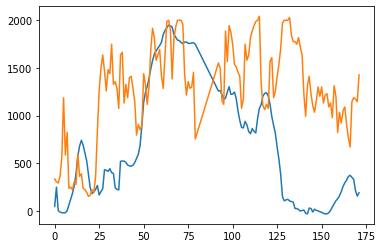

In [50]:
plt.plot(df_out.Predicted_Power)
plt.plot(df_out.Power)

In [20]:
df_merged = pd.merge(df_out,juvent_data[juvent_data.Turbine_id==wt_dict[wt]],left_on='Date-time', right_on='Time')
#drop eventual duplicates due to overlapping forecasts
df_merged = df_merged.drop_duplicates(subset='Date-time', keep="first") 
df_merged = df_merged.sort_values(by='Date-time').reset_index(drop=True)

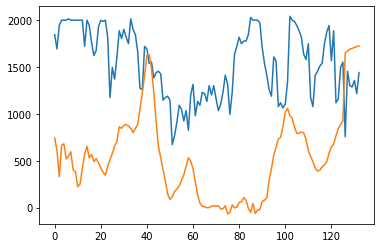

In [21]:
plt.plot(df_merged.Power)
plt.plot(df_merged.Predicted_Power)

In [91]:
wt_dict[wt]

1

In [ ]:
wnn=WNN.WindNeuralNetwork()